In [33]:
!pip install pmdarima

In [34]:
# All import statements go here

import statsmodels
import random
from numpy import random as rnd1
from tabulate import tabulate
import numpy as np
import pandas as pd
import scipy
from itertools import repeat
from sklearn.linear_model import LinearRegression
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
import pandas.util.testing as tm
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt


##supress warnings
import warnings
warnings.filterwarnings('ignore')

In [35]:
#All function definitions go here

def init_elast_dist(num_rows, num_cols):
  res0 = [[1 for i in range(num_cols)] for j in range(num_rows) ]
  for l in range(0, num_rows):
    for k in range(0,num_cols):
      res0[l][k] = round( random.uniform(-3, -1), 2 )
  
  return np.array(res0)

def init_epsilon_vector(num_cols, epsilon_mean, epsilon_std):
  res1 = [1 for i in range(num_cols)]
  for l in range(0, num_cols):
    res1[l] = round( scipy.stats.norm(epsilon_mean, epsilon_std).pdf(1.5) , 1 )
  
  return np.array(res1)

def init_price_vector(num_rows, num_cols):
  res2 = [ [1]*num_cols for i in range(num_rows) ]
  for l in range(0, num_rows):
    if l == 0:
      for j in range(0, num_cols):
        res2[l][j] = round( random.uniform(5.0, 10.0), 1 )
    elif l>=1 and l<=5:
      for k in range(0, num_cols):
        res2[l][k] = round( random.uniform(10.0, 20.0), 1 )
    elif l>5 and l<=8:
      for k in range(0, num_cols):
        res2[l][k] = round( random.uniform(20.0, 30.0), 1 )
    else:
      for k in range(0, num_cols):
        res2[l][k] = round( random.uniform(30.0, 40.0), 1 )
  
  return np.array(res2)

def init_demand_vector(num_rows, num_cols):
  res2 = [ [0]*num_cols for i in range(num_rows) ]
  for l in range(0, num_rows):
    for k in range(0, num_cols):
      res2[l][k] = float(random.randint(1,5))

  return np.array(res2)

def init_forecast_vector(num_rows, num_cols):
  res2 = [ [0]*num_cols for i in range(num_rows) ]
  for l in range(0, num_rows):
    for k in range(0,num_cols):
      res2[l][k] = float(random.randint(1,5))
  
  return np.array(res2)


def generate_init_data(price_vector, forecast_vector, demand_vector, elasticity_distrib, epsilon_vector, number_items_basket, Time_period, c_zero, Beta):
  elasticity_distrib = init_elast_dist(number_items_basket, Time_period)

  #creating a guassian epsilon vector
  epsilon_mean = 0
  epsilon_std = 1
  epsilon_vector = init_epsilon_vector(Time_period, epsilon_mean, epsilon_std)

  #initializing price(i,0) of all items in the basket as 12
  price_vector = init_price_vector(number_items_basket, Time_period)
  #initializing demand vector
  demand_vector = init_demand_vector(number_items_basket, Time_period)
  #initializing forecast vector
  forecast_vector = init_forecast_vector(number_items_basket, Time_period)
  

  for nrow in range(0, number_items_basket):
    for ncol in range(0, Time_period):
      if ncol > 0:
        forecast_vector[nrow][ncol] = round( ( ((demand_vector[nrow][ncol])/((price_vector[nrow][ncol]/price_vector[nrow][ncol-1])**(elasticity_distrib[nrow][ncol]))) ) , 1 )

  ret_arr_init = [None]*5
  ret_arr_init[0] = price_vector
  ret_arr_init[1] = forecast_vector
  ret_arr_init[2] = demand_vector
  ret_arr_init[3] = elasticity_distrib
  ret_arr_init[4] = epsilon_vector

  return ret_arr_init


def Demand_Modeller(price_item, forecast_item, demand_item, elasticity_distrib, epsilon_vector, num_rows, num_cols, c_zero, Beta):
  #holds forecast at time t
  
  vect_f = []
  vect_e = []
  vect_p = []
  vect_d = []
  vect_r = []
  prev_price1 = price_item[: , num_cols-1]

  for i in range(0,num_rows):
    dem_sum = 0
    for j in range(0, (num_cols)):
      dem_sum = dem_sum + ((Beta**(num_cols-j))*(demand_item[i][j]))
    pred_val1 = round((c_zero + dem_sum + epsilon_vector[num_cols-1]), 1)
    vect_f.append(pred_val1)

    model_e = auto_arima(elasticity_distrib[i], start_p=0, start_q=0)
    pred_val2 = model_e.predict(n_periods = 1)
    vect_e.append(round(pred_val2[0], 2))

    model_p = auto_arima(price_item[i], start_p=0, start_q=0)
    pred_val3 = model_p.predict(n_periods = 1)
    vect_p.append(round(pred_val3[0], 1))

    terma = pred_val1
    termb = round(pred_val3[0], 1)
    termc = round(pred_val2[0], 2)
    pred_val4 = (terma)*( (termb/prev_price1[i])**(termc) )
    pred_val4 = pred_val4 + (epsilon_vector[num_cols-1])
    pred_val5 = round( max(pred_val4,0) )
    vect_d.append(pred_val5)

  vect_r.append(vect_f)
  vect_r.append(vect_e)
  vect_r.append(vect_p)
  vect_r.append(vect_d)
  return vect_r



def Demand_Modeller_Guassian(price_item, forecast_item, demand_item, elasticity_distrib, epsilon_vector, num_rows, num_cols, elasticity_new_a, c_zero, Beta):
  #holds forecast at time t
  
  vect_f = []
  vect_p = []
  vect_d = []
  vect_r = []
  prev_price1 = price_item[: , num_cols-1]


  for i in range(0,num_rows):
    dem_sum = 0
    for j in range(0, (num_cols)):
      dem_sum = dem_sum + ((Beta**(num_cols-j))*(demand_item[i][j]))
    pred_val1 = round((c_zero + dem_sum + epsilon_vector[num_cols-1]), 1)
    vect_f.append(pred_val1)

    pred_val2 = elasticity_new_a[i]

    model_p = auto_arima(price_item[i], start_p=0, start_q=0)
    pred_val3 = model_p.predict(n_periods = 1)
    vect_p.append(round(pred_val3[0], 1))

    terma = pred_val1
    termb = round(pred_val3[0], 1)
    termc = round(pred_val2, 2)
    pred_val4 = (terma)*( (termb/prev_price1[i])**(termc) )
    pred_val4 = pred_val4 + (epsilon_vector[num_cols-1])
    pred_val5 = round( max(pred_val4,0) )
    vect_d.append(pred_val5)

  vect_r.append(vect_f)
  vect_r.append(vect_p)
  vect_r.append(vect_d)
  return vect_r

##Revenue Calculation code

def Increment_price_passive(price_arr, index):
  price_arr1 = np.array(price_arr).copy()
  if (price_arr1[index]+1) <= 20:
    price_arr1[index] = price_arr1[index] + 1
  
  return price_arr1


def Calculate_Revenue_Passive(price_passive, price_passive_minus_one, Baseline_demand_passive, elast_distrib_passive, number_items_basket):
  Revenue_passive1 = 0
  for iter1 in range(0, number_items_basket):
    Revenue_passive1 = Revenue_passive1 + (price_passive[iter1]*price_passive[iter1]*Baseline_demand_passive[iter1]*elast_distrib_passive[iter1]/price_passive_minus_one[iter1]) - (price_passive[iter1]*Baseline_demand_passive[iter1]*elast_distrib_passive[iter1]) + (price_passive[iter1]*Baseline_demand_passive[iter1])
  
  return Revenue_passive1

def Find_Optimal_Price_Basket(price_passive, price_passive_minus_one, Baseline_demand_passive, elast_distrib_passive, number_items_basket):
  rev_pass2 = 0
  rev_pass3 = 0
  for iter1 in range(0, number_items_basket):
    rev_pass2 = Calculate_Revenue_Passive(price_passive, price_passive_minus_one, Baseline_demand_passive, elast_distrib_passive, number_items_basket)
    rev_pass3 = Calculate_Revenue_Passive(Increment_price_passive(price_passive, iter1), price_passive_minus_one, Baseline_demand_passive, elast_distrib_passive, number_items_basket)
    while rev_pass3 > rev_pass2:
      price_passive = Increment_price_passive(price_passive, iter1)
      rev_pass2 = Calculate_Revenue_Passive(price_passive, price_passive_minus_one, Baseline_demand_passive, elast_distrib_passive, number_items_basket)
      rev_pass3 = Calculate_Revenue_Passive(Increment_price_passive(price_passive, iter1), price_passive_minus_one, Baseline_demand_passive, elast_distrib_passive, number_items_basket)
  
  #print(rev_pass2, "--------------", rev_pass3)
  ret_array_p = [None]*2
  ret_array_p[0] = np.array(price_passive)
  ret_array_p[1] = round(rev_pass2,1)

  return ret_array_p


##Additional Guassian Functions - new code
def compute_theta_vector(price_vector, price_vector_prev, forecast_vector, number_items_basket):
  r_array = np.zeros(number_items_basket)
  for j1 in range(0,number_items_basket):
    r_array[j1] = round( ( ((price_vector[j1]*price_vector[j1]*forecast_vector[j1])/(price_vector_prev[j1])) - (price_vector[j1]*forecast_vector[j1]) ), 1)
  
  return r_array

def compute_revenue_bar_vector(price_vector, forecast_vector, number_items_basket):
  r_array1 = np.zeros(number_items_basket)
  for j1 in range(0,number_items_basket):
    r_array1[j1] = round( (price_vector[j1]*forecast_vector[j1]), 1)
  
  return r_array1

def compute_revenue_vector(price_vector, demand_vector, number_items_basket):
  r_array1 = np.zeros(number_items_basket)
  for j1 in range(0,number_items_basket):
    r_array1[j1] = round( (price_vector[j1]*demand_vector[j1]), 1)
  
  return r_array1

def compute_array_sum(vector, number_items_basket):
  arr_sum1 = 0
  for j1 in range(0,number_items_basket):
    arr_sum1 = arr_sum1 + vector[j1]
  
  return round(arr_sum1 , 1)

def Generate_New_Elasticity_Guassian(price_vector, price_vector_prev, forecast_vector, demand_vector, number_items_basket, elasticity_mean, cov_matrix, std_dev_dist, lambda_const):
  ##Code for -- guassian prior on elasticity vector and the associated modification of mean and covariance vectors
  theta_vector = compute_theta_vector(price_vector, price_vector_prev, forecast_vector, number_items_basket)
  revenue_bar_vector = compute_revenue_bar_vector(price_vector, forecast_vector, number_items_basket)
  revenue_vector = compute_revenue_vector(price_vector, demand_vector, number_items_basket)

  #Performing the necessary matrix operations
  theta_2d = np.asmatrix(theta_vector.reshape(-1,1))
  theta_2d_t = np.asmatrix(theta_vector.reshape(1,-1))
  theta_2d_mult1 = np.dot(theta_2d, theta_2d_t)
  theta_2d_mult2 = theta_2d_mult1*(1/(std_dev_dist*std_dev_dist))
  temp_id_arr1 = np.asmatrix(np.identity(number_items_basket, dtype = float))
  temp_id_arr2 = temp_id_arr1*lambda_const
  M_t_inv = np.add(theta_2d_mult2, temp_id_arr2)

  cov_inv = np.linalg.inv(np.asmatrix(cov_matrix))
  temp_inv_1 = np.add(M_t_inv, cov_inv)
  cov_mod = np.linalg.inv(temp_inv_1) ##modified covariance

  elasticity_mean_2d = np.asmatrix(elasticity_mean.reshape(-1,1))

  temp_part1 = np.dot(cov_inv, elasticity_mean_2d)

  rev_bar_sum = compute_array_sum(revenue_bar_vector, number_items_basket)
  rev_bar = compute_array_sum(revenue_vector, number_items_basket)
  temp_part2_mult = ((rev_bar - rev_bar_sum)/(std_dev_dist*std_dev_dist))
  temp_part2 = theta_2d*temp_part2_mult

  temp_part3 = np.add(temp_part1, temp_part2)
  elasticity_mean_mod = np.dot(cov_mod, temp_part3)  #modified elasticity mean vector

  cov_mod_arr = np.asarray(cov_mod)
  elasticity_mean_mod_arr = np.asarray(elasticity_mean_mod)
  guassian_x = np.random.multivariate_normal(mean=elasticity_mean_mod_arr.flatten(), cov=cov_mod_arr, size=6)
  elasticity_new_x = guassian_x[random.randint(0,5) , :]  #randomly sampling for the new elasticity vector

  ret_arr_x = [None]*3
  ret_arr_x[0] = cov_mod_arr
  ret_arr_x[1] = elasticity_mean_mod_arr.flatten()
  ret_arr_x[2] = elasticity_new_x

  
  return ret_arr_x



In [36]:
#All code goes in the below section
#initialize all vectors
price_vector = np.array([])
forecast_vector = np.array([])
demand_vector = np.array([])
elasticity_distrib = np.array([])
epsilon_vector = np.array([])
init_out = np.array([])

number_items_basket = 12       ##This is the number of items in a basket
#Step 1 -- generate base dataset for a fixed time period (30 days of data)
Time_period = 10

c_zero = 0.19  ##taking c0 as a small positive constant as suggested in the paper
Beta = 0.5
std_dev_dist = 1
lambda_const = 0.18  ##taking lambda as a small positive constant as suggested in the paper

epsilon_mean = 0
epsilon_std = 1

init_out = generate_init_data(price_vector, forecast_vector, demand_vector, elasticity_distrib, epsilon_vector, number_items_basket, Time_period, c_zero, Beta)
price_vector = init_out[0]
forecast_vector = init_out[1]
demand_vector = init_out[2]
elasticity_distrib = init_out[3]
epsilon_vector = init_out[4]

##added code starts here
elasticity_mean = np.array(np.mean(elasticity_distrib, axis = 1))
cov_matrix1 = np.identity(number_items_basket, dtype = float)
cov_matrix2 = cov_matrix1*c_zero
guassian_0 = np.random.multivariate_normal(mean=elasticity_mean, cov=cov_matrix2, size=6)
elasticity_new1 = guassian_0[random.randint(0,5) , :]
##added code ends here

print("price vector")
print(tabulate(price_vector, tablefmt="fancy_grid"))
print()

print("forecast vector")
print(tabulate(forecast_vector, tablefmt="fancy_grid"))
print()

print("demand vector")
print(tabulate(demand_vector, tablefmt="fancy_grid"))
print()

print("elasticity vector")
print(tabulate(elasticity_distrib, tablefmt="fancy_grid"))
print()

# print("epsilon vector")
# print(tabulate(epsilon_vector.reshape(1,-1), tablefmt="fancy_grid"))
# print()

##added code starts here
# print("initial elasticity mean vector")
# print(tabulate(elasticity_mean.reshape(-1,1), tablefmt="fancy_grid"))
# print()

# print("initial covariance matrix")
# print(tabulate(cov_matrix2, tablefmt="fancy_grid"))
# print()


price vector
╒══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╕
│  7.8 │  9.1 │  5.7 │  5   │  6.7 │  7.2 │  5.8 │  7.2 │  9   │  6.6 │
├──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┤
│ 15.4 │ 17.8 │ 12.3 │ 10.3 │ 15.3 │ 10.7 │ 14   │ 15   │ 18.4 │ 18.8 │
├──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┤
│ 10.2 │ 11.3 │ 14.8 │ 16.4 │ 13.9 │ 10.8 │ 17   │ 10.2 │ 12.7 │ 19.7 │
├──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┤
│ 13.1 │ 16.1 │ 18.6 │ 13.3 │ 13.2 │ 18.3 │ 16.6 │ 19.7 │ 10.2 │ 16   │
├──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┤
│ 15.9 │ 17.9 │ 18   │ 10.5 │ 13.6 │ 17.2 │ 12.5 │ 16.8 │ 19.7 │ 16.2 │
├──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┤
│ 18.6 │ 11.9 │ 11.5 │ 13.3 │ 18.9 │ 13.2 │ 19.4 │ 10.6 │ 13.9 │ 11.9 │
├──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┼──────┤
│ 20.2 │ 23.3 │ 23.7 │ 22.5 │ 21.2 │ 26.1 │ 20.5 │ 

In [37]:
#Projecting for titer periods - To see the comparative performace of Passive vs Active models

titer = 60  ##number of periods for which prices have to be forecasted upto
num_trails_con = 10   ##number of trails conducted, over which the revenue is averaged (suggested number is 10 according to paper)
x1 = np.zeros(titer)
rev_arr10 = np.zeros(titer)
rev_arr11 = np.zeros(titer)

price_vector_final_p = np.array([])
forecast_vector_final_p = np.array([])
demand_vector_final_p = np.array([])
elasticity_distrib_final_p = np.array([])

price_vector_final_a = np.array([])
forecast_vector_final_a = np.array([])
demand_vector_final_a = np.array([])
elasticity_distrib_final_a = np.array([])


for temp_c in range(0,titer):
  x1[temp_c] = temp_c + 1

#print("x1_shape: ", x1.shape)

for jiter in range(0, num_trails_con):
  Time_period1 = Time_period
  Time_period2 = Time_period
  price_vector1 = price_vector.copy()
  price_vector2 = price_vector.copy()
  forecast_vector1 = forecast_vector.copy()
  forecast_vector2 = forecast_vector.copy()
  demand_vector1 = demand_vector.copy()
  demand_vector2 = demand_vector.copy()
  elasticity_distrib1 = elasticity_distrib.copy()
  elasticity_distrib2 = elasticity_distrib.copy()
  epsilon_vector1 = epsilon_vector.copy()
  epsilon_vector2 = epsilon_vector.copy()

  elasticity_new_a = elasticity_new1.copy()
  #print("round %i: " %(jiter+1))
  #print()

  for iter3 in range(0,titer):
    dm_x1 = Demand_Modeller(price_vector1, forecast_vector1, demand_vector1, elasticity_distrib1, epsilon_vector1, number_items_basket, Time_period1, c_zero, Beta)
    Baseline_demand_f_x1 = np.array(dm_x1[0])
    elast_f_x1 = np.array(dm_x1[1])
    price_f_x1 = np.array(dm_x1[2])
    demand_f_x1 = np.array(dm_x1[3])

    #append newly generated columns for Passive Algorithm
    forecast_vector1 = np.append(forecast_vector1, Baseline_demand_f_x1.reshape(-1,1), axis=1)
    elasticity_distrib1 = np.append(elasticity_distrib1, elast_f_x1.reshape(-1,1), axis=1)
    price_vector1 = np.append(price_vector1, price_f_x1.reshape(-1,1), axis=1)
    demand_vector1 = np.append(demand_vector1, demand_f_x1.reshape(-1,1), axis=1)
    epsilon_vector1 = np.append(epsilon_vector1, round( scipy.stats.norm(epsilon_mean, epsilon_std).pdf(1.5) , 1 ) )
    Time_period1 = Time_period1 + 1

    dm_x2 = Demand_Modeller_Guassian(price_vector2, forecast_vector2, demand_vector2, elasticity_distrib2, epsilon_vector2, number_items_basket, Time_period2, elasticity_new_a, c_zero, Beta)
    Baseline_demand_f_x2 = np.array(dm_x2[0])
    price_f_x2 = np.array(dm_x2[1])
    demand_f_x2 = np.array(dm_x2[2])
    elast_f_x2 = Generate_New_Elasticity_Guassian(price_f_x2, price_vector2[:, (Time_period2 - 1)], Baseline_demand_f_x2, demand_f_x2, number_items_basket, elasticity_mean, cov_matrix2, std_dev_dist, lambda_const)
    new_cov1 = elast_f_x2[0]
    new_mean_el1 = elast_f_x2[1]
    elast_new_vect = elast_f_x2[2]

    elast_f_x2_new = elast_new_vect.copy()
    elasticity_new_a = elast_new_vect.copy()
    elasticity_mean = new_mean_el1.copy()
    cov_matrix2 = new_cov1.copy()


    ## updation
    price_vector_final_p = price_f_x1
    forecast_vector_final_p = Baseline_demand_f_x1
    demand_vector_final_p = demand_f_x1
    elasticity_distrib_final_p = elast_f_x1

    price_vector_final_a = price_f_x2
    forecast_vector_final_a = Baseline_demand_f_x2
    demand_vector_final_a = demand_f_x2
    elasticity_distrib_final_a = elast_f_x2
    
    #append newly generated columns for Active Algorithm
    forecast_vector2 = np.append(forecast_vector2, Baseline_demand_f_x2.reshape(-1,1), axis=1)
    elasticity_distrib2 = np.append(elasticity_distrib2, elast_f_x2_new.reshape(-1,1), axis=1)
    price_vector2 = np.append(price_vector2, price_f_x2.reshape(-1,1), axis=1)
    demand_vector2 = np.append(demand_vector2, demand_f_x2.reshape(-1,1), axis=1)
    epsilon_vector2 = np.append(epsilon_vector2, round( scipy.stats.norm(epsilon_mean, epsilon_std).pdf(1.5) , 1 ) )
    Time_period2 = Time_period2 + 1

    price_vec_minus_one1 = price_vector1[:, (Time_period1-2)]
    price_vec_minus_one2 = price_vector2[:, (Time_period2-2)]


    opt_pb1 = Find_Optimal_Price_Basket(price_f_x1, price_vec_minus_one1, Baseline_demand_f_x1, elast_f_x1, number_items_basket)
    opt_pb2 = Find_Optimal_Price_Basket(price_f_x2, price_vec_minus_one2, Baseline_demand_f_x2, elast_f_x2_new, number_items_basket)

    price_opt1 = opt_pb1[0]
    revenue_opt1 = opt_pb1[1]
    # print("Revenue projected by the passive algoritm for period %i: " %Time_period1, revenue_opt1)
    # print()

    price_opt2 = opt_pb2[0]
    revenue_opt2 = opt_pb2[1]
    # print("Revenue projected by the active algoritm for period %i: " %Time_period2, revenue_opt2)
    # print()
    
    rev_arr10[iter3] = rev_arr10[iter3] + revenue_opt1
    rev_arr11[iter3] = rev_arr11[iter3] + revenue_opt2

#calculating average revenue across trails
avg_rev10 = np.divide(rev_arr10, num_trails_con)
avg_rev11 = np.divide(rev_arr11, num_trails_con)



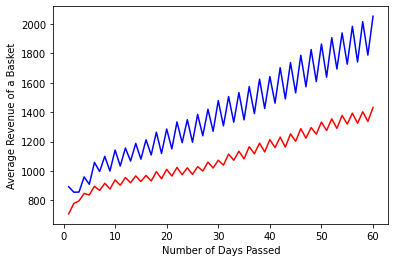

In [38]:
# print("Average revenue Generated across the basket (Passive) : ")
# print(tabulate(avg_rev10.reshape(-1,1), tablefmt="fancy_grid"))
# print()

# print("Average revenue Generated across the basket (Active) : ")
# print(tabulate(avg_rev11.reshape(-1,1), tablefmt="fancy_grid"))
# print()

plt.plot(x1, avg_rev11, 'b')
plt.plot(x1, avg_rev10, 'r')
plt.xlabel("Number of Days Passed")
plt.ylabel("Average Revenue of a Basket")
plt.show()

### Note: 'Blue line' represents active model, while the 'Red Line' represents passive model -- Active model greatly outperforms the passive model as suggested in the paper

In [39]:
print("Final Price vector passive: ")
print(tabulate(price_vector_final_p.reshape(-1,1), tablefmt="fancy_grid"))
print()

print("Final Price vector active: ")
print(tabulate(price_vector_final_a.reshape(-1,1), tablefmt="fancy_grid"))
print()


Final Price vector passive: 
╒══════╕
│  7   │
├──────┤
│ 14.8 │
├──────┤
│ 13.8 │
├──────┤
│ 15.5 │
├──────┤
│ 15.8 │
├──────┤
│ 14.2 │
├──────┤
│ 22.8 │
├──────┤
│ 24.1 │
├──────┤
│ 24.8 │
├──────┤
│ 33.8 │
├──────┤
│ 34.8 │
├──────┤
│ 36.1 │
╘══════╛

Final Price vector active: 
╒══════╕
│  7   │
├──────┤
│ 14.8 │
├──────┤
│ 13.8 │
├──────┤
│ 15.5 │
├──────┤
│ 15.8 │
├──────┤
│ 14.2 │
├──────┤
│ 22.8 │
├──────┤
│ 24.1 │
├──────┤
│ 24.8 │
├──────┤
│ 33.8 │
├──────┤
│ 34.8 │
├──────┤
│ 36.1 │
╘══════╛

